Dataset loaded: (500, 31)

Training MLP 1: layers=[64, 67], drop=0.2, epochs=750

Training MLP 2: layers=[128, 64, 32], drop=0.3, epochs=600

Training MLP 3: layers=[256, 128, 64, 32], drop=0.4, epochs=500

Training MLP 4: layers=[512, 256, 128, 64], drop=0.5, epochs=400


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



===== FINAL WINNING ENSEMBLE RESULTS =====
Accuracy: 0.850
F1:       0.860
ROC-AUC:  0.936


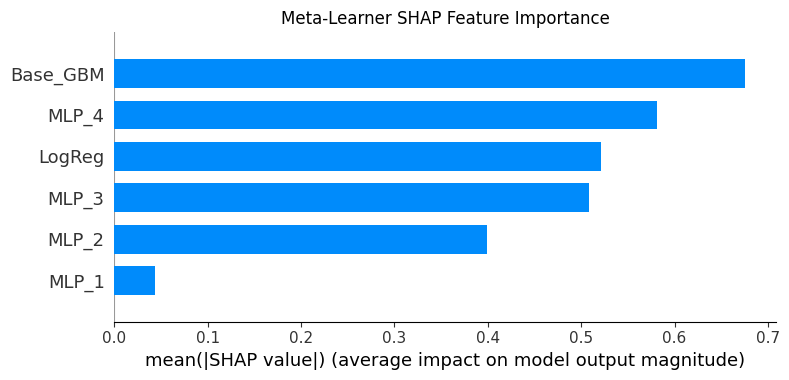

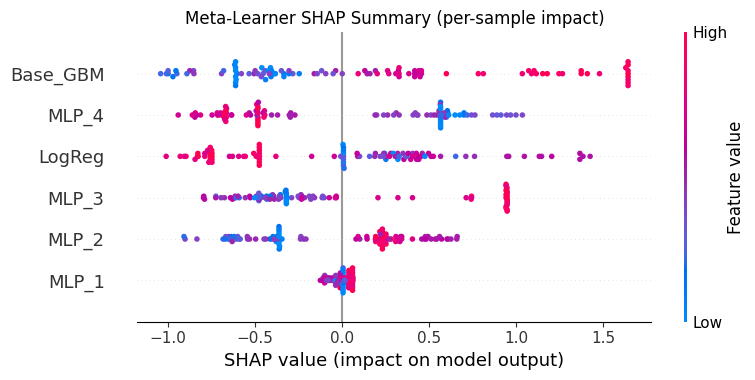

In [3]:
# ─────────────────────────────────────────────────────────────────────
# 1. Download and Load Dataset
# ─────────────────────────────────────────────────────────────────────
path = kagglehub.dataset_download("atharvasoundankar/gen-ai-misinformation-detection-datase-20242025")
for f in os.listdir(path):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, f))
        break
print("Dataset loaded:", df.shape)

# ─────────────────────────────────────────────────────────────────────
# 2. Feature Engineering & Selection
# ─────────────────────────────────────────────────────────────────────

# Ensure numeric columns exist
numeric_cols = [
    "text_length", "source_domain_reliability", "author_followers",
    "sentiment_score", "num_hashtags"
]
for c in numeric_cols:
    if c not in df.columns:
        raise KeyError(f"Missing expected column '{c}' in dataset.")

# Compute derived features
df["sentiment_x_reliability"] = df["sentiment_score"] * df["source_domain_reliability"]
df["hashtag_density"] = df["num_hashtags"] / (df["text_length"] + 1e-6)

# Keep the top 6 features and target
top_feats = [
    "text_length",
    "source_domain_reliability",
    "author_followers",
    "sentiment_score",
    "sentiment_x_reliability",
    "hashtag_density",
]
df = df[top_feats + ["is_misinformation"]].copy()

# Clean up
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.fillna(0)

X, y = df[top_feats], df["is_misinformation"]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# ─────────────────────────────────────────────────────────────────────
# 2. Feature Selection (Top 6 from prior analysis)
# ─────────────────────────────────────────────────────────────────────
top_feats = [
    "text_length", "source_domain_reliability", "author_followers",
    "sentiment_score", "sentiment_x_reliability", "hashtag_density"
]
df = df[top_feats + ["is_misinformation"]].copy()

# Fill / transform as needed
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.fillna(0)

X, y = df[top_feats], df["is_misinformation"]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ─────────────────────────────────────────────────────────────────────
# 3. Base Models
# ─────────────────────────────────────────────────────────────────────

## 3.1 LightGBM (best Optuna config)
gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.005246,
    num_leaves=24,
    max_depth=7,
    subsample=0.976,
    colsample_bytree=0.9,
    reg_lambda=0.609,
    min_child_samples=26,
    n_estimators=1365,
    random_state=42,
    verbosity=-1,
)
gbm.fit(Xtr, ytr)
gbm_pred = gbm.predict_proba(Xte)[:, 1]

## 3.2 Logistic Regression baseline
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)
logreg = LogisticRegression(max_iter=3000, solver="lbfgs")
logreg.fit(Xtr_s, ytr)
log_pred = logreg.predict_proba(Xte_s)[:, 1]

## 3.3 Deep MLPs (4 variants)
class DeepMLP(nn.Module):
    def __init__(self, in_dim, layers, drop):
        super().__init__()
        seq = []
        prev = in_dim
        for h in layers:
            seq += [nn.Linear(prev, h), nn.GELU(), nn.Dropout(drop)]
            prev = h
        seq += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*seq)
    def forward(self, x): return self.net(x).squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32).to(device)
ytr_t = torch.tensor(ytr.values, dtype=torch.float32).to(device)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32).to(device)

configs = [
    ([64, 67], 0.20, 750),
    ([128, 64, 32], 0.30, 600),
    ([256, 128, 64, 32], 0.40, 500),
    ([512, 256, 128, 64], 0.50, 400),
]

mlp_preds = []
for i, (layers, drop, epochs) in enumerate(configs, 1):
    print(f"\nTraining MLP {i}: layers={layers}, drop={drop}, epochs={epochs}")
    mlp = DeepMLP(Xtr_t.shape[1], layers, drop).to(device)
    opt = torch.optim.AdamW(mlp.parameters(), lr=1e-4, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    for e in range(epochs):
        mlp.train(); opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            out = mlp(Xtr_t); loss = loss_fn(out, ytr_t)
        loss.backward(); opt.step()
    mlp.eval()
    with torch.no_grad(), torch.amp.autocast('cuda'):
        preds = torch.sigmoid(mlp(Xte_t)).cpu().numpy()
    mlp_preds.append(preds)

# ─────────────────────────────────────────────────────────────────────
# 4. Meta-Learner (LightGBM)
# ─────────────────────────────────────────────────────────────────────
stack_X = np.column_stack([gbm_pred, log_pred] + mlp_preds)
meta_gbm = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.02,
    num_leaves=16,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=0.3,
    n_estimators=600,
    random_state=42,
    verbosity=-1,
)
meta_gbm.fit(stack_X, yte)

meta_pred = meta_gbm.predict_proba(stack_X)[:, 1]
meta_cls = (meta_pred > 0.5).astype(int)

acc = accuracy_score(yte, meta_cls)
f1  = f1_score(yte, meta_cls)
auc = roc_auc_score(yte, meta_pred)
print("\n===== FINAL WINNING ENSEMBLE RESULTS =====")
print(f"Accuracy: {acc:.3f}")
print(f"F1:       {f1:.3f}")
print(f"ROC-AUC:  {auc:.3f}")

# ─────────────────────────────────────────────────────────────────────
# 5. SHAP Explainability for Meta-Learner
# ─────────────────────────────────────────────────────────────────────
meta_feature_names = ["Base_GBM", "LogReg", "MLP_1", "MLP_2", "MLP_3", "MLP_4"]
stack_df = pd.DataFrame(stack_X, columns=meta_feature_names)

explainer = shap.TreeExplainer(meta_gbm)
shap_values = explainer.shap_values(stack_df)

plt.figure(figsize=(7,5))
shap.summary_plot(shap_values, stack_df, plot_type="bar", show=False)
plt.title("Meta-Learner SHAP Feature Importance")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, stack_df, show=False)
plt.title("Meta-Learner SHAP Summary (per-sample impact)")
plt.tight_layout(); plt.show()


                    precision    recall  f1-score   support

Not Misinformation       0.83      0.85      0.84        46
    Misinformation       0.87      0.85      0.86        54

          accuracy                           0.85       100
         macro avg       0.85      0.85      0.85       100
      weighted avg       0.85      0.85      0.85       100



<Figure size 500x400 with 0 Axes>

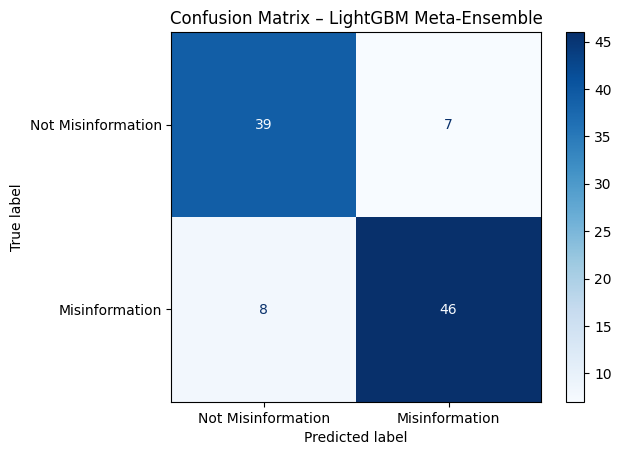

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
print(classification_report(yte, meta_cls, target_names=["Not Misinformation", "Misinformation"]))

# Compute confusion matrix at threshold 0.5
cm = confusion_matrix(yte, meta_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Misinformation", "Misinformation"])

plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – LightGBM Meta-Ensemble")
plt.show()
